# Cheminf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rdkit.Chem as rdc
import pandas as pd

from rdkit.Chem.rdMolDescriptors import CalcExactMolWt, CalcMolFormula
from rdkit.Chem import Draw
import copy

Implement Morgans Algorithm to generate unique serial numbers of the atoms in a molecule. 
input format?


Needs to take in a molecular adjacency matrix, and output a numbering. 

iterates through the atoms neighbours, sums the values up from all the neighbours up until the number of unique values doesn't change. 

stick with the first one that gave you that number of unique values

assign priorities using the same order as the final set of sums of values for each atom



In [32]:
df = pd.read_csv("./data/Husskonen_Solubility_Features.csv")

In [33]:
df.SMILES

0                        c1ccc2ccc3nccnc3c2c1
1                           c1cnc2c(C)ncnc2n1
2                           c1cnc2cnc(C)nc2n1
3                           c1c(C)nc2cncnc2n1
4                          c1cnc2c(OC)ncnc2n1
                        ...                  
927                  c1ccccc1N2C(=O)C=C(C)N2C
928                 n(c(nc(n1)NC(C)C)NCC)c1Cl
929            CCC1(C(=O)NC(=O)NC1=O)c2ccccc2
930               O=C(N(C)C)Nc(ccc(c1Cl)Cl)c1
931    O=C(N(N=CC(OC(N(=O)=O)=C1)=C1)CC2=O)N2
Name: SMILES, Length: 932, dtype: object

In [34]:
ms = df.SMILES[3]

In [35]:
mol = rdc.MolFromSmiles(ms)

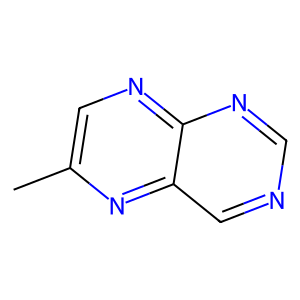

In [36]:
rdc.Draw.MolToImage(mol)

In [37]:
aspirin_smiles = 'CC(Oc1ccccc1C(O)=O)=O'
aspirin = rdc.MolFromSmiles(aspirin_smiles)

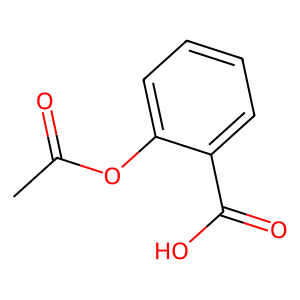

In [38]:
rdc.Draw.MolToImage(aspirin)

In [39]:
aspirin_smiles = 'O=C(C)Oc1ccccc1C(=O)O'
aspirin = rdc.MolFromSmiles(aspirin_smiles)

In [10]:
smile = 'C'
mols = []
for i in range(16):
    mol = rdc.MolFromSmiles(smile)
    mols.append(mol)
    rdc.Draw.MolToImage(mol).show()
    
    smile += 'C'


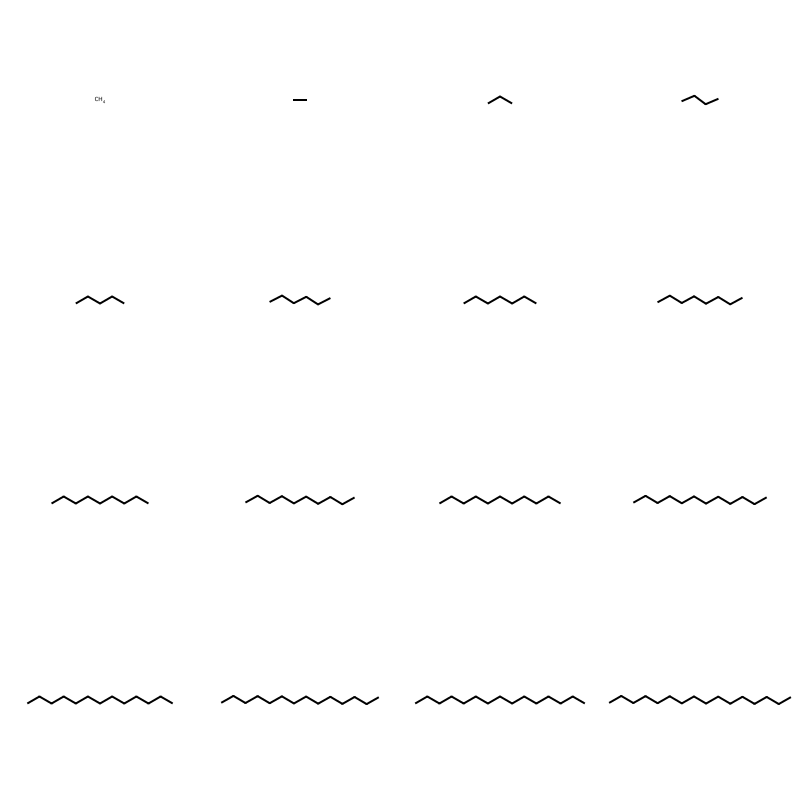

In [11]:
rdc.Draw.MolsToGridImage(mols, molsPerRow=4)

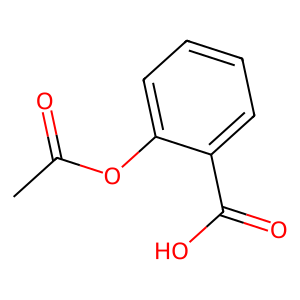

In [40]:
rdc.Draw.MolToImage(aspirin)

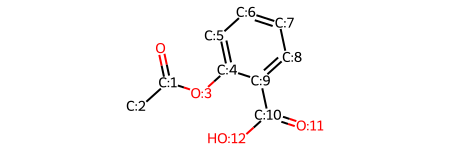

In [41]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

mol = mol_with_atom_index(aspirin)
mol

In [42]:
adj = rdc.rdmolops.GetAdjacencyMatrix(aspirin)

In [43]:
adj_df = pd.DataFrame(adj)
els = [atom.GetSymbol() for atom in aspirin.GetAtoms()]
adj_df = pd.DataFrame(adj, index=els,  columns=els)

In [44]:
adj_df

,O,C,C,O,C,C,C,C,C,C,C,O,O
O,0,1,0,0,0,0,0,0,0,0,0,0,0
C,1,0,1,1,0,0,0,0,0,0,0,0,0
C,0,1,0,0,0,0,0,0,0,0,0,0,0
O,0,1,0,0,1,0,0,0,0,0,0,0,0
C,0,0,0,1,0,1,0,0,0,1,0,0,0
C,0,0,0,0,1,0,1,0,0,0,0,0,0
C,0,0,0,0,0,1,0,1,0,0,0,0,0
C,0,0,0,0,0,0,1,0,1,0,0,0,0
C,0,0,0,0,0,0,0,1,0,1,0,0,0
C,0,0,0,0,1,0,0,0,1,0,1,0,0


In [45]:
# routine to get neighbours of each atom 

def find_neighbours(adj_df):
    atoms = adj_df.columns
    num_atoms = len(atoms) # counts non H atoms
    neighbours = {} # builds dictionary

    for node in range(num_atoms):
        neighbours[node] = []
        for neighbour in range(num_atoms):
            if adj_df.iloc[node][neighbour]: # 1 evaluates as true
                neighbours[node].append(neighbour)

    return neighbours


# Find neighbours
graph_neighbours = find_neighbours(adj_df)
atoms = adj_df.columns

# Print neighbours
for atom, neighbours in graph_neighbours.items():
    print(f"Node  {atoms[atom]}{atom} neighbours: {neighbours}")


Node  O0 neighbours: [1]
Node  C1 neighbours: [0, 2, 3]
Node  C2 neighbours: [1]
Node  O3 neighbours: [1, 4]
Node  C4 neighbours: [3, 5, 9]
Node  C5 neighbours: [4, 6]
Node  C6 neighbours: [5, 7]
Node  C7 neighbours: [6, 8]
Node  C8 neighbours: [7, 9]
Node  C9 neighbours: [4, 8, 10]
Node  C10 neighbours: [9, 11, 12]
Node  O11 neighbours: [10]
Node  O12 neighbours: [10]


In [64]:
def count_unique(arr):
    """counts number of unique values"""
    unique_vals = np.unique(arr)
    return len(unique_vals)

def atom_sums_to_indices(sums):
    """
    this will take in the atoms sums and return a priority list
    index need not be unique
    finds lowest number is highest priority
    """
    priority = 1
    priorities = np.ones(len(sums))*-1
    while np.count_nonzero(sums) > 0:
        print(sums)
        
        i = np.argmin(sums)
        min_num = sums[i]
        inds = np.where(sums==min_num) # may not be unique
        sums[inds] = len(sums)+1# set to one more than the lrgest possible value
        priorities[inds] = priority
        priority+=1
        if priority==3:
            break
        
    return priorities
        
def assign_labels(priorities, mol):
    """
    puts labels on molecule
    """
    for at in mol.GetAtoms():
        lbl = '%.d'%(priorities[at.GetIdx()])
        at.SetProp('atomNote',lbl)   
    
    


def morgan(adj_df, mol):
    """
    takes in adjacency matrix outputs a numbering for each atom
    uses https://bigchem.eu/sites/default/files/Martin_Vogt_algorithms_in_cheminformatics_150519.pdf
    and Leach and Gilet book. 
    """
    a, a = adj_df.shape # gets non H atom count
    #initialises 
    atoms = np.ones(a) #initialse values
    atom_sums = np.zeros(a) #somewhere to put the values
    
    #gets neighbours
    n_dict = find_neighbours(adj_df)
    diff = -1
    mol_lst = []
    leg_lst = []
    img_lst = []
    n_unique = count_unique(atom_sums)
    step=0
    while diff !=0:

        # iterate through each atom
        for i in range(a): 
            ns = n_dict[i]
            atom_sums[i] = sum([x for x in atoms[ns]]) # should not update till the end

        diff = n_unique - count_unique(atom_sums)

        n_unique = count_unique(atom_sums)
        atoms = atom_sums.copy() # update 
        assign_labels(atom_sums, mol)
        step+=1
        leg_lst.append(f"n={n_unique}")
        mol_lst.append(copy.deepcopy(mol))
        img = Draw.MolToImage(mol)
        img_lst.append(img)
        img.save(f'images/step{step}_morgan.png')
        
        if diff ==0:
            break
    return atoms, mol_lst, leg_lst, img_lst

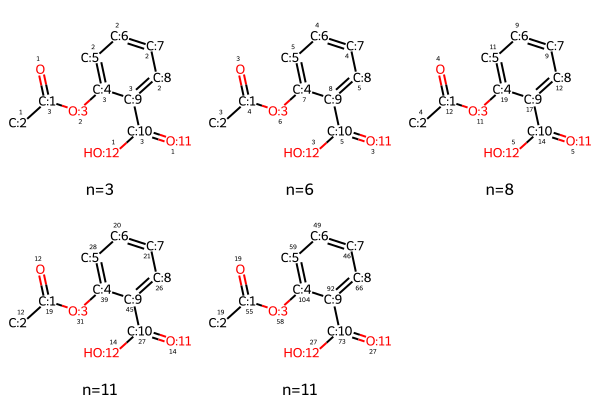

In [65]:
sums, mol_lst, leg_lst, img_lst = morgan(adj_df, aspirin)
Draw.MolsToGridImage(mol_lst, legends=leg_lst)

In [63]:
for img in img_lst:
    img.show()

In [ ]:
priorities = atom_sums_to_indices(sums)

In [ ]:
atom_sums_to_indices(sums)

In [ ]:
np.where()